In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

2024-07-02 22:18:15.048139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 22:18:15.048226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 22:18:15.206281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Blight = ['/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight']
Common_Rust = ['/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust']
Gray_Leaf_Spot = ['/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot']
Healthy = ['/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Healthy']
file_p = []
labels = []
dict_lists = [Blight, Common_Rust,Gray_Leaf_Spot,Healthy]
class_labels = ['Blight', 'Common_Rust','Gray_Leaf_Spot','Healthy']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [3]:
df.head()

,filepaths,labels
0,/kaggle/input/corn-or-maize-leaf-disease-datas...,Blight
1,/kaggle/input/corn-or-maize-leaf-disease-datas...,Blight
2,/kaggle/input/corn-or-maize-leaf-disease-datas...,Blight
3,/kaggle/input/corn-or-maize-leaf-disease-datas...,Blight
4,/kaggle/input/corn-or-maize-leaf-disease-datas...,Blight


In [4]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2669, 2)
(1047, 2)
(472, 2)


In [5]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2669 validated image filenames belonging to 4 classes.
Found 1047 validated image filenames belonging to 4 classes.
Found 472 validated image filenames belonging to 4 classes.


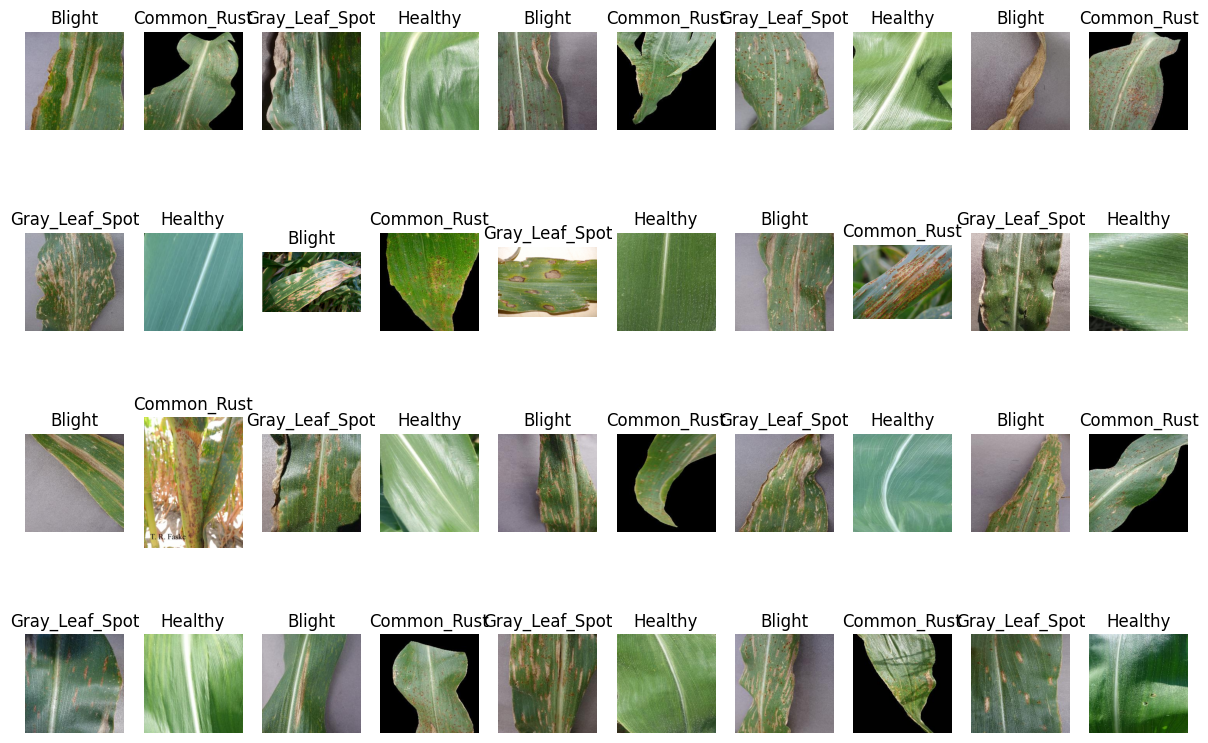

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()


In [8]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax

# Load pre-trained MobileNet model without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3),pooling='max')

# Add custom top layers for your specific task
x = base_model.output
x = BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=20, validation_data=val)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719958818.348253     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719958818.447722     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/84 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - accuracy: 0.3441 - loss: 2.1658 

W0000 00:00:1719958874.516279     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7056 - loss: 0.9156

W0000 00:00:1719958901.321505     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7069 - loss: 0.9112 - val_accuracy: 0.3114 - val_loss: 1.4101
Epoch 2/20


W0000 00:00:1719958914.674325     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.9500 - loss: 0.1401 - val_accuracy: 0.2945 - val_loss: 1.8768
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9820 - loss: 0.0599 - val_accuracy: 0.1165 - val_loss: 2.4463
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.9905 - loss: 0.0417 - val_accuracy: 0.3199 - val_loss: 3.4840
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.9898 - loss: 0.0328 - val_accuracy: 0.3856 - val_loss: 3.5340
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.9993 - loss: 0.0128 - val_accuracy: 0.4280 - val_loss: 3.3521
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.9975 - loss: 0.0139 - val_accuracy: 0.5275 - val_loss: 2.0626
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.9980 - loss: 0.0120 - val_accuracy: 0.7267 - val_loss: 0.8524
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.803

In [9]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - accuracy: 0.9713 - loss: 0.1441
Test Loss: 0.23485973477363586
Test Accuracy: 0.9617956280708313


W0000 00:00:1719959242.081514     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


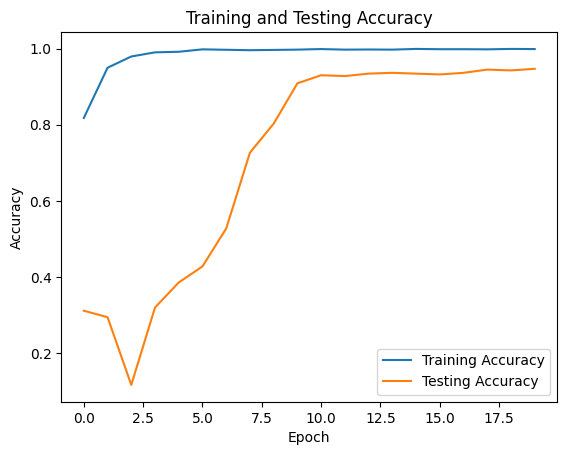

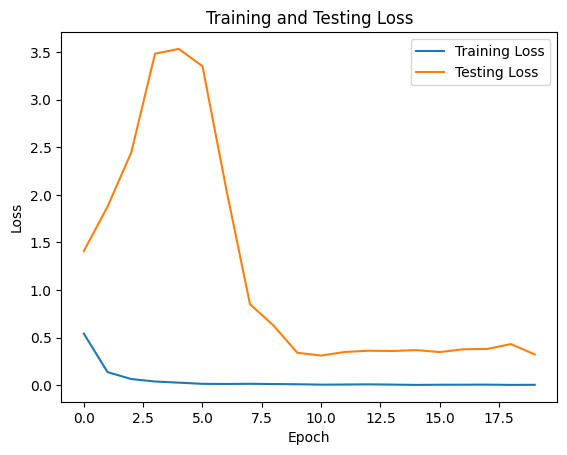

In [10]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

 3/33 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

W0000 00:00:1719959248.631475     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step


W0000 00:00:1719959258.414982     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


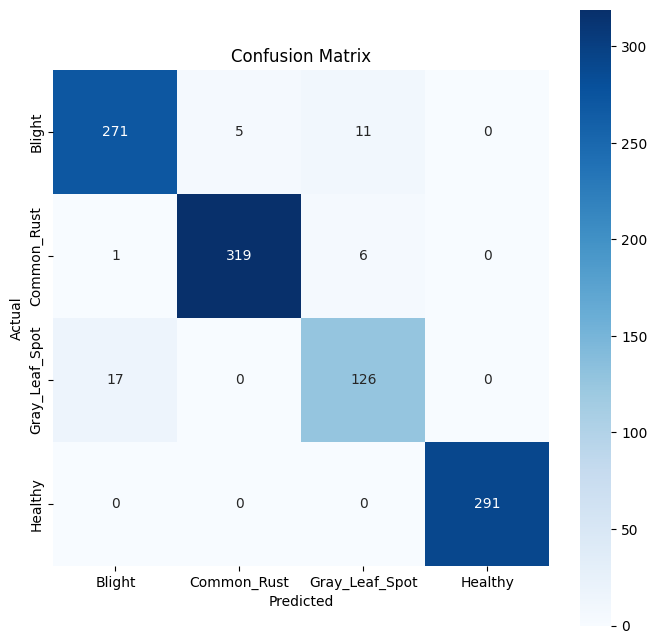

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
model.save("Corn_efficientnet_model.h5")

In [13]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

3.2.1
2.15.0
